In [28]:
from database.adatabase import ADatabase
from extractor.alp_client_extractor import ALPClientExtractor
from extractor.tiingo_extractor import TiingoExtractor
from processor.processor import Processor as processor
from datetime import datetime, timedelta
from tqdm import tqdm 
from dotenv import load_dotenv
load_dotenv()
import os
import pandas as pd
from time import sleep
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema


In [55]:
# Initialize parameters
window = 300
gain_window = 60
extractor = ALPClientExtractor(os.getenv("APCAKEY"), os.getenv("APCASECRET"))
tickers = ["AAVE", "AVAX", "BAT", "BTC", "CRV", "DOGE", "DOT", "ETH", "GRT", "LINK", "LTC", "MKR", "SHIB", "SUSHI", "UNI", "XTZ", "YFI"]
tickers = [x + "/USD" for x in tickers]

prices = []
start = datetime.now() - timedelta(days=5)
end = datetime.now()

# Loop through each ticker to fetch prices and calculate metrics
for ticker in tickers:
    response = extractor.crypto_interval(ticker, start)
    price = pd.DataFrame(response["bars"][ticker]).rename(columns={"c": "adjclose", "t": "date"})[["date", "adjclose"]]
    
    # Convert date and sort
    price["date"] = pd.to_datetime(price["date"])
    price = price.sort_values("date")
    
    # Calculate metrics
    price["rolling_return"] = ((price["adjclose"].rolling(window).mean() - price["adjclose"]) / price["adjclose"])
    price["bollinger"] = ((price["adjclose"].rolling(window).mean() - price["adjclose"].rolling(window).std() - price["adjclose"]) / price["adjclose"])
    price["return"] = price["adjclose"].pct_change(gain_window)
    price["avg_return"] = price["return"].pct_change(gain_window).rolling(window).mean()
    price["coev"] = (price["adjclose"].rolling(window).mean() / price["adjclose"].rolling(window).std())
    price["ticker"] = ticker
    prices.append(price)

# Combine all prices into a single DataFrame
sim = pd.concat(prices).sort_values("date").dropna()

In [56]:
sim

,date,adjclose,rolling_return,bollinger,return,avg_return,coev,ticker
309,2024-09-22 06:22:00+00:00,0.161162,0.006933,-0.000282,0.001376,1.434074,139.563301,GRT/USD
310,2024-09-22 06:24:00+00:00,0.161181,0.006743,-0.000433,0.001059,1.427975,140.306668,GRT/USD
311,2024-09-22 06:25:00+00:00,0.161120,0.007050,-0.000093,-0.000806,1.409376,140.992320,GRT/USD
312,2024-09-22 06:26:00+00:00,0.161190,0.006542,-0.000558,0.000124,1.439806,141.767645,GRT/USD
313,2024-09-22 06:27:00+00:00,0.161100,0.007029,-0.000030,0.001150,1.461185,142.659108,GRT/USD
...,...,...,...,...,...,...,...,...
5003,2024-09-27 08:19:00+00:00,29.744300,-0.012786,-0.020413,0.000215,-3.906523,129.432123,AVAX/USD
5077,2024-09-27 08:19:00+00:00,0.123729,-0.023073,-0.040680,0.002098,-2.433950,55.484845,DOGE/USD
3921,2024-09-27 08:19:00+00:00,0.198162,-0.014101,-0.023699,0.000134,-1.891281,102.712537,BAT/USD
6706,2024-09-27 08:19:00+00:00,0.189002,-0.010320,-0.021187,-0.000920,0.850574,91.071285,GRT/USD


In [57]:
metrics = [
    "rolling_return",
    "bollinger",
    "return",
    "avg_return",
    "coev"
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1153.13it/s]


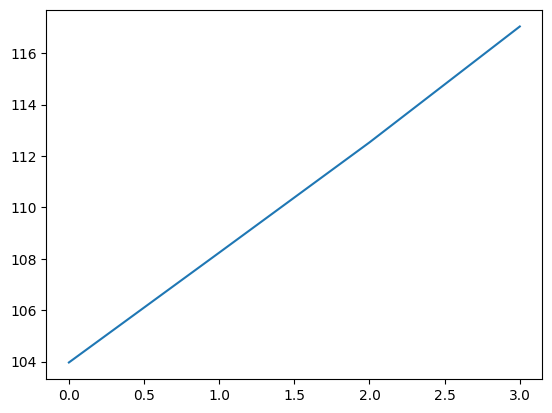

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1145.90it/s]


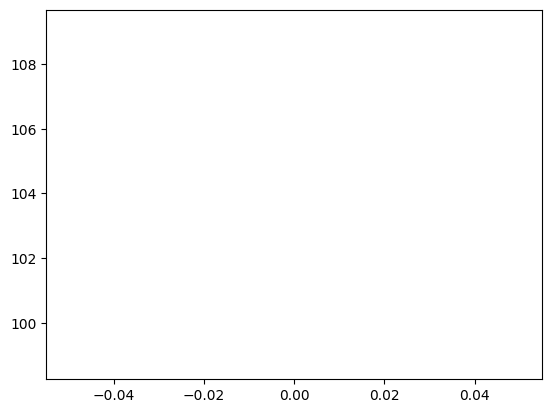

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1150.02it/s]


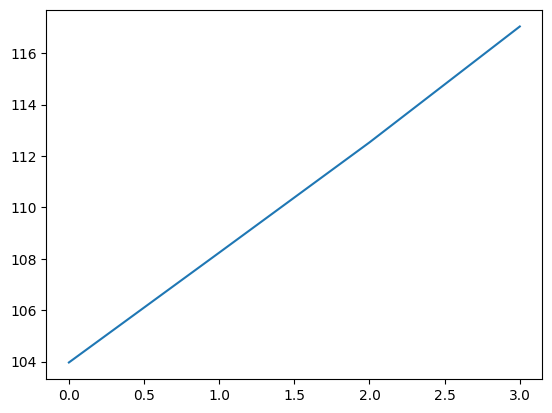

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1139.77it/s]


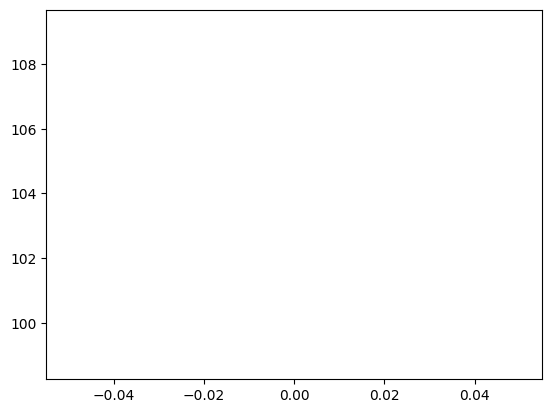

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1144.25it/s]


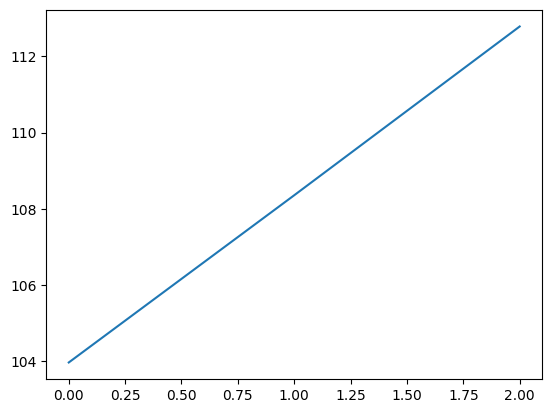

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1141.78it/s]


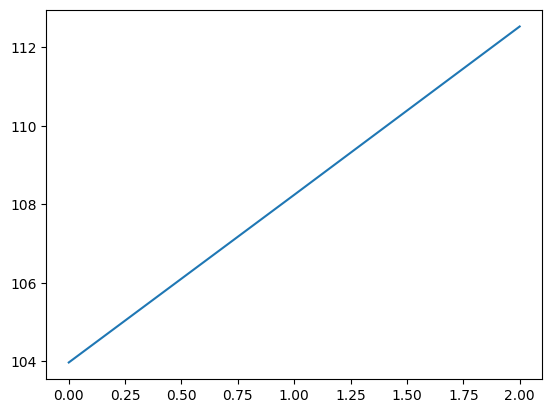

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1141.06it/s]


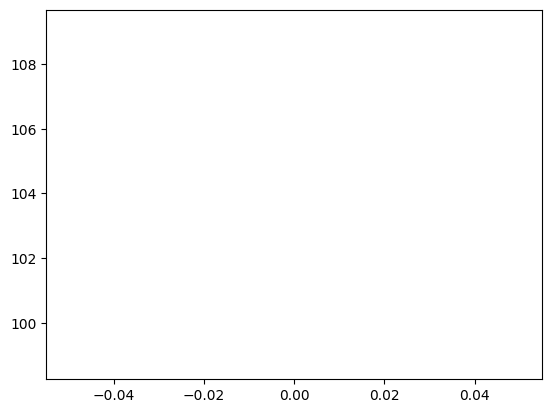

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1139.36it/s]


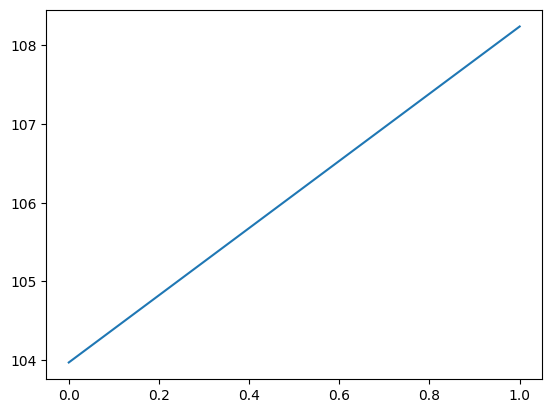

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1141.27it/s]


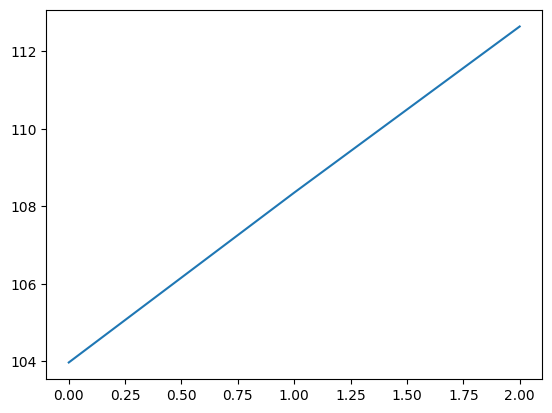

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7305/7305 [00:06<00:00, 1127.87it/s]


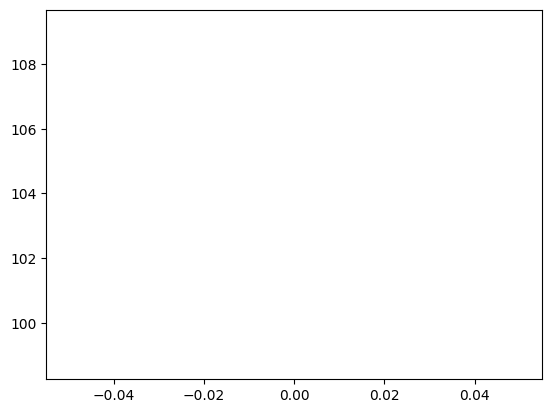

In [58]:
import copy
analysis = []
date_range = list(sim["date"].unique())
base_position = {"date":date_range[0],"ticker":"","quantity":0,"adjclose":0,"buy_price":0,"buy_date":date_range[0]}
for metric in metrics:
    for ascending in [True,False]:
        cash = 100
        position = copy.deepcopy(base_position)
        cashes = []
        for date in tqdm(date_range):
            try:
                position = copy.deepcopy(position)
                position["date"] = date
                today = sim[sim["date"]==date]
                if today.index.size >= 0:
                    opportunity = today.sort_values(metric,ascending=ascending).iloc[0]
                    if position["ticker"] != "":
                        position["adjclose"] = today[today["ticker"]==position["ticker"]]["adjclose"].iloc[0].item()
                        pnl_req = ((position["adjclose"] - position["buy_price"]) / position["buy_price"] >= 0.05)
                        loss_req = ((position["adjclose"] - position["buy_price"]) / position["buy_price"] <= -0.05)
                        hpr_req = (date - position["buy_date"]).days > float(1/24)
                        if pnl_req or loss_req:
                            try:
                                cash = position["adjclose"] * position["quantity"] * 0.99
                                cashes.append(cash)
                                position = copy.deepcopy(base_position)
                                position["date"] = date
                                position["ticker"] = opportunity["ticker"]
                                position["quantity"] = cash / opportunity["adjclose"] 
                                position["adjclose"] = opportunity["adjclose"]
                                position["buy_price"] = opportunity["adjclose"]
                                position["buy_date"] = date
                            except Exception as e:
                                continue
                    else:
                        position["date"] = date
                        position["ticker"] = opportunity["ticker"]
                        position["quantity"] = cash / opportunity["adjclose"] 
                        position["adjclose"] = opportunity["adjclose"]
                        position["buy_price"] = opportunity["adjclose"]
                        position["buy_date"] = date
            except Exception as e:
                continue
        position["metric"] = metric
        position["ascending"] = ascending
        position["pv"] = position["adjclose"] * position["quantity"]
        plt.plot(cashes)
        plt.show()
        analysis.append(copy.deepcopy(position))

In [59]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False)

,date,ticker,quantity,adjclose,buy_price,buy_date,metric,ascending,pv
0,2024-09-27 08:19:00+00:00,DOGE/USD,955.450141,0.123729,0.122496,2024-09-27 06:02:00+00:00,rolling_return,True,118.216891
2,2024-09-27 08:19:00+00:00,DOGE/USD,955.450141,0.123729,0.122496,2024-09-27 06:02:00+00:00,bollinger,True,118.216891
4,2024-09-27 08:19:00+00:00,BTC/USD,0.001756,65600.569500,64212.500000,2024-09-24 20:59:00+00:00,return,True,115.218528
8,2024-09-27 08:19:00+00:00,XTZ/USD,154.339180,0.740675,0.729850,2024-09-26 12:14:00+00:00,coev,True,114.315172
5,2024-09-27 08:19:00+00:00,GRT/USD,602.066250,0.189002,0.186908,2024-09-24 22:54:00+00:00,return,False,113.792026
7,2024-09-27 08:19:00+00:00,BAT/USD,565.051019,0.198162,0.191560,2024-09-23 06:32:00+00:00,avg_return,False,111.971923
1,2024-09-27 08:19:00+00:00,BTC/USD,0.001620,65600.569500,64166.483500,2024-09-23 03:09:00+00:00,rolling_return,False,106.292333
3,2024-09-27 08:19:00+00:00,BTC/USD,0.001620,65600.569500,64166.483500,2024-09-23 03:09:00+00:00,bollinger,False,106.292333
9,2024-09-27 08:19:00+00:00,BTC/USD,0.001620,65600.569500,64166.483500,2024-09-23 03:09:00+00:00,coev,False,106.292333
6,2024-09-27 08:19:00+00:00,CRV/USD,346.035172,0.307109,0.300457,2024-09-23 03:09:00+00:00,avg_return,True,106.270689
